In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import time
from copy import copy
from tqdm.notebook import tqdm
from multiprocessing import Pool
from simulation import Simulation_Base
from mip_solver import MIP_solver
from pycryptosat import Solver

class Simulation_D(Simulation_Base):
    number = 3
    
    def __init__(self, silent=False):
        Simulation_Base.__init__(self, number=self.number, silent=silent)
        
        self.ind_books2 = np.argwhere(self.book_num_libs == 2).reshape(-1)
        self.ind_books3 = np.argwhere(self.book_num_libs == 3).reshape(-1)
        
        self.books2_set = set(list(self.ind_books2))
        self.books3_set = set(list(self.ind_books3))
        self.lib_books2_list = []
        self.lib_books3_list = []
        for books in self.lib_books_lists:
            books2 = []
            books3 = []
            for book in books:
                if book in self.books2_set:
                    books2.append(book)
                else:
                    books3.append(book)
                    
            self.lib_books2_list.append(books2)
            self.lib_books3_list.append(books3)
            
        self.lib_num_books2 = np.array([len(books2) for books2 in self.lib_books2_list])
        self.lib_num_books3 = np.array([len(books3) for books3 in self.lib_books3_list])
        
    def compute_best_libs(self):
        libs1 = []
        libs2 = []
        for book in self.ind_books2:
            libs = self.book_libs_lists[book]
            libs1.append(libs[0])
            libs2.append(libs[1])
        libs1 = np.array(libs1)
        libs2 = np.array(libs2)
        
        libs1_set = set(libs1)
        libs2_set = set(libs2)
        
        self.num_variables = len(libs1)
        self.lib_variable = np.arange(self.num_variables * 2)
        self.variable_lib_dict = dict()
        
        for ind in range(self.num_variables):
            variable = ind + 1
            lib1 = libs1[ind]
            lib2 = libs2[ind]
            self.lib_variable[lib1] = variable
            self.lib_variable[lib2] = -variable
            self.variable_lib_dict[variable] = lib1
            self.variable_lib_dict[-variable] = lib2
        
        self.clauses = []
        for book3 in self.ind_books3:
            libs = self.book_libs_lists[book3]
            clause = [int(self.lib_variable[lib]) for lib in libs]
            self.clauses.append(clause)
        
        s = Solver(threads = 10)
        
        # Uncomment for computing libs
#         for clause in self.clauses:
#             s.add_clause(clause)
#         satisfied, sol_sat = s.solve(delete=False)
        
        satisfied, sol_sat = s.read_solution("crypto_out_1582880164.827717.txt", delete=False)   
        
        ind_libs_best = []
        for variable in range(1, self.num_variables+1):
            position = int(sol_sat[variable])
            polarity = position * 2 - 1
            lib = self.variable_lib_dict[polarity * variable]
            ind_libs_best.append(lib)
        self.ind_libs_best = np.array(ind_libs_best)
        
    def compute_best_order_and_books(self):
        self.mip = MIP_solver(self)
        self.solution = self.mip.get_optimal_books_for_ordered_libs(self.ind_libs_best)
        self.solution[-1][1].append(12313123)
        ind_libs_num_books = np.array([len(books) for lib, books in self.solution])
        ind_libs_sorted = np.argsort(-ind_libs_num_books)
        self.ind_libs_best = self.ind_libs_best[ind_libs_sorted]
        self.solution = self.mip.get_optimal_books_for_ordered_libs(self.ind_libs_best)
        
    def run(self):
        t0 = time()
        self.compute_best_libs()
        t1 = time()
        print("computing best libs done: ", t1-t0)
        self.compute_best_order_and_books()
        t2 = time()
        print("computing best order and books done: ", t2-t1)
        

        
sim = Simulation_D()
sim.run()
print(sim.get_score())
# sim.write()

computing best libs done:  0.15097713470458984
computing best order and books done:  37.457082748413086
5109000


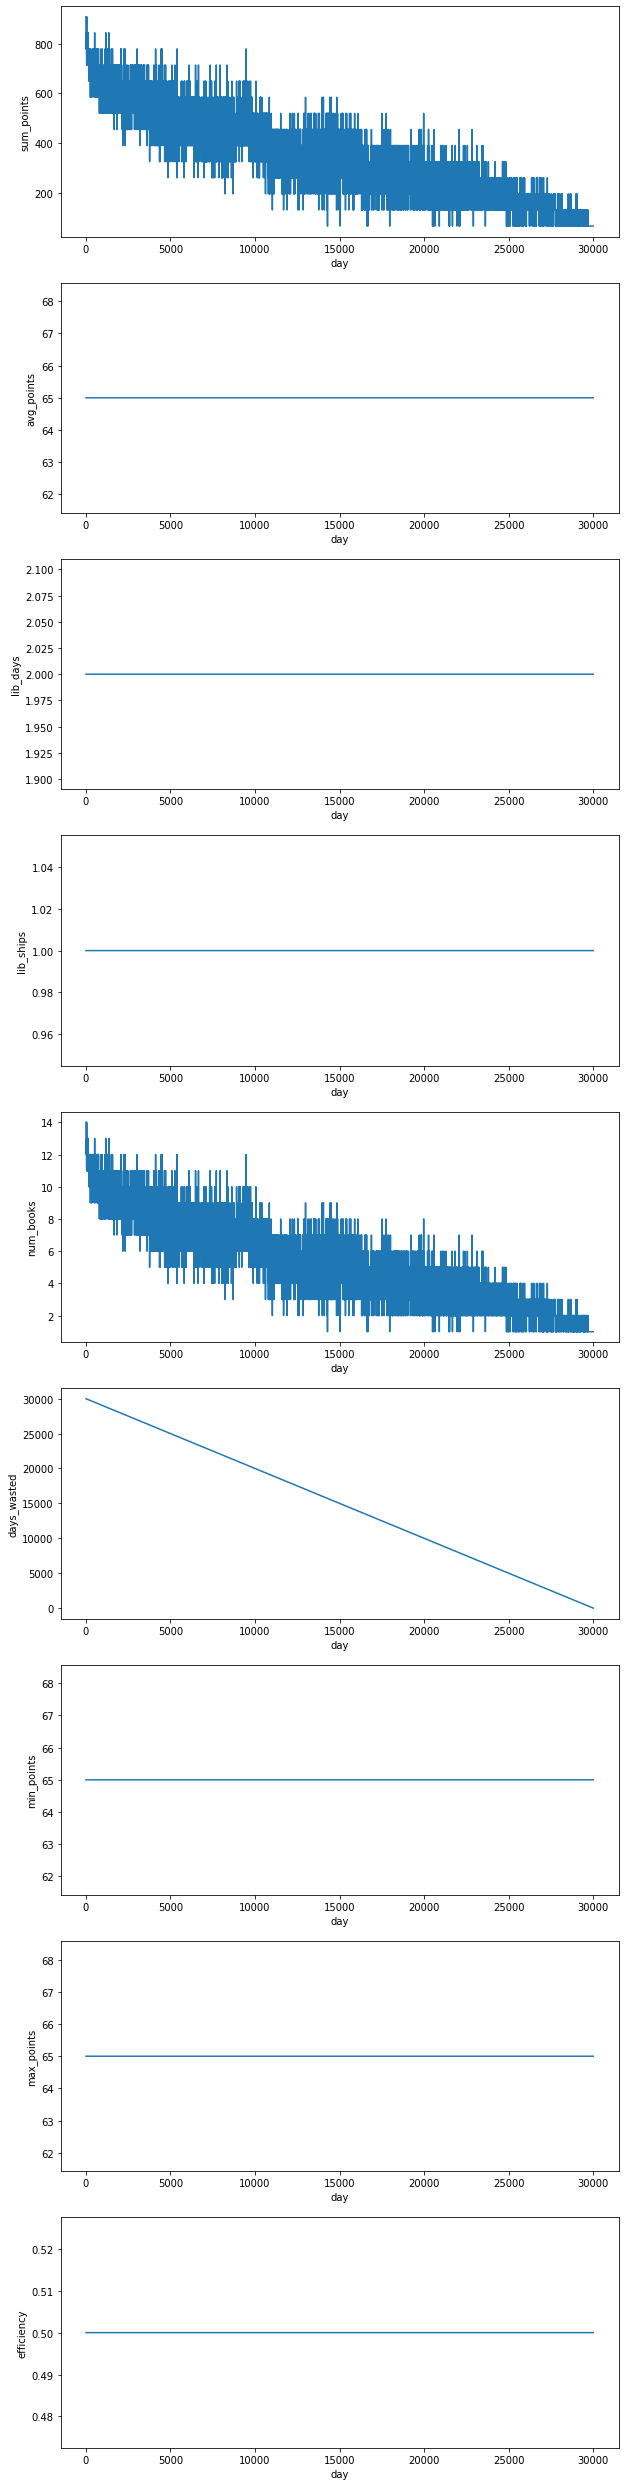

In [5]:
sim.plot_solution()